In [4]:
import tensorflow as tf
import os
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

if not os.path.isdir('models'):
    os.mkdir('models')
    
print("Tensorflow version:", tf.__version__)
print("Is using GPU:", tf.test.is_gpu_available())

Tensorflow version: 2.1.0
Is using GPU: True


In [7]:
def get_three_classes(X,y):
    
    # Getting indices of first three classes
    indices0, _ = np.where( y == 0)
    indices1, _ = np.where( y == 1)
    indices2, _ = np.where( y == 2)
    
    # Concatenating the indices
    indices = np.concatenate([indices0, indices1, indices2], axis = 0)
    
    # Getting the value of corresponding indices
    X = X[indices]
    y = y[indices]
    
    # Getting total number of data examples
    count = X.shape[0]
    
    # Shuffling the dataset
    indices = np.random.choice(range(count), count, replace=False)
    
    X = X[indices]
    y = y[indices]
    
    # converting the labels to one-hot vector
    y = tf.keras.utils.to_categorical(y)
    
    return X, y

In [20]:
# Downloading dataset

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, y_train = get_three_classes(x_train, y_train)
x_test, y_test = get_three_classes(x_test, y_test)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(15000, 32, 32, 3) (15000, 3)
(3000, 32, 32, 3) (3000, 3)


In [21]:
class_names = ['aeroplane', 'car', 'bird']

In [22]:
def show_random_examples(x, y, p):
    
    # shuffling the dataset and get 10 random values from it
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    # get the values from the dataset
    x = x[indices]
    y = y[indices]
    p = p[indices] # prediction, if we have
    
    plt.figure(figsize=(10,5))
    for i in range(10):
        plt.subplot(2, 5, 1+i)
        plt.imshow(x[i])
        
        # for clear image
        plt.xticks([])
        plt.yticks([])
        
        # getting the output label color, if right then green else red
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        
        plt.xlabel(class_names[np.argmax(p[i])], color = col)
    
    plt.show()

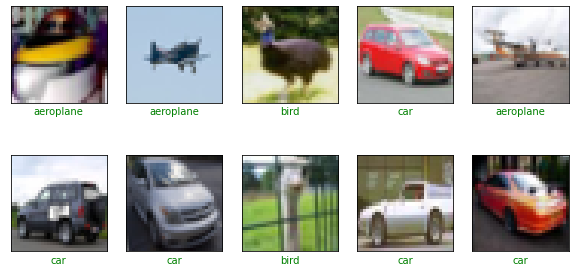

In [23]:
show_random_examples(x_train, y_train, y_train)

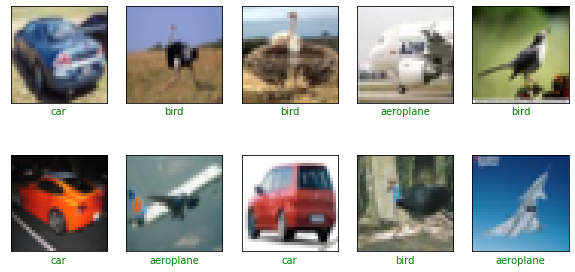

In [24]:
show_random_examples(x_test, y_test, y_test)

In [25]:
# importing the libraries for cnn
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input, Dropout, BatchNormalization

In [30]:
def create_model():
    def add_conv_block(model, num_filters):
        # output: img x img x num_filters
        model.add(Conv2D(num_filters, 3, activation='relu', padding='same'))
        model.add(BatchNormalization())
        
        # output: (img-2) x (img-2) x num_filters 
        model.add(Conv2D(num_filters, 3, activation='relu'))
        
        #output: ((img-2)/2) x ((img-2)/2) x num_filters
        model.add(MaxPooling2D(pool_size=2))
        model.add(Dropout(0.5))
        
        return model
    
    model = tf.keras.models.Sequential()
    
    #input layer
    model.add(Input(shape = (32,32,3)))
    
    # first Convolutional layer
    model = add_conv_block(model, 32)
    model = add_conv_block(model, 64)
    model = add_conv_block(model, 128)
    
    # Flatten layer 
    model.add(Flatten())
    
    
    # Fully connected layer 1 as hidden layer
    model.add(Dense(10, activation='relu'))
    
    # Fully connected layer 2 as hidden layer
    model.add(Dense(12, activation='relu'))
    
    # Fully connected layer 3 as output layer
    model.add(Dense(3, activation='softmax'))
    
    # run model
    model.compile(
        # cost function
        loss = 'categorical_crossentropy',
        optimizer = 'adam',
        metrics=['accuracy']
    )
    
    return model

In [31]:
model = create_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 15, 15, 64)        18496     
_________________________________________________________________
batch_normalization_7 (Batch (None, 15, 15, 64)       

In [32]:
# run the model
h = model.fit(
    x_train/255., y_train,
    validation_data = (x_test/255., y_test),
    epochs = 10, 
    batch_size=128, # minibatch size
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
        tf.keras.callbacks.ModelCheckpoint(
            'models/model_{val_accuracy:.3f}.h5',
            save_best_only=True,
            save_weights_only=False,
            monitor = 'val_accuracy'
        )
    ]
)

Train on 15000 samples, validate on 3000 samples
Epoch 1/10
15000/15000 [==============================] - 4s 286us/sample - loss: 0.7526 - accuracy: 0.6711 - val_loss: 2.0470 - val_accuracy: 0.3337
Epoch 2/10
15000/15000 [==============================] - 3s 219us/sample - loss: 0.5406 - accuracy: 0.7850 - val_loss: 2.9795 - val_accuracy: 0.3333
Epoch 3/10
15000/15000 [==============================] - 3s 222us/sample - loss: 0.4775 - accuracy: 0.8103 - val_loss: 3.0061 - val_accuracy: 0.3443
Epoch 4/10
15000/15000 [==============================] - 3s 222us/sample - loss: 0.4231 - accuracy: 0.8321 - val_loss: 2.4985 - val_accuracy: 0.3743
Epoch 5/10
15000/15000 [==============================] - 3s 223us/sample - loss: 0.3912 - accuracy: 0.8498 - val_loss: 0.9265 - val_accuracy: 0.6703
Epoch 6/10
15000/15000 [==============================] - 3s 222us/sample - loss: 0.3533 - accuracy: 0.8616 - val_loss: 0.8258 - val_accuracy: 0.7053
Epoch 7/10
15000/15000 [===========================

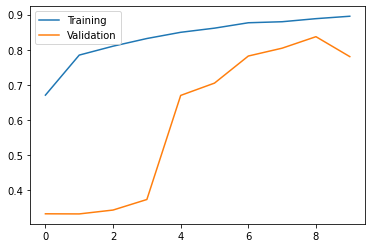

In [35]:
# plot accuracy

acc = h.history['accuracy']
val_accs = h.history['val_accuracy']

plt.plot(range(len(acc)), acc, label="Training")
plt.plot(range(len(val_accs)), val_accs, label="Validation")
plt.legend()
plt.show()

In [36]:
# Predition time
#Load model

model = tf.keras.models.load_model('models/model_0.892.h5')

In [37]:
predictions = model.predict(x_test/255.)

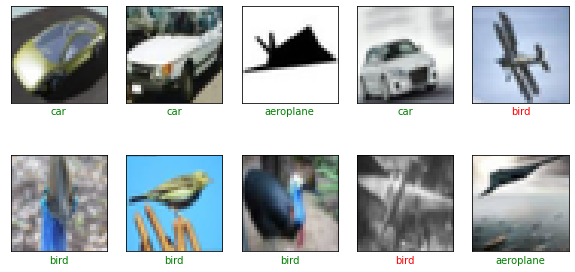

In [38]:
show_random_examples(x_test, y_test, predictions)